## Part 2

In this part of the project, you will compare the output of two linguistic processing libraries (e.g., Stanza vs. Spacy). Using a given set
of texts, you will run both libraries on these texts and report statistics
on how often they (dis)agree with respect to the task of named entity
recognition. For ease of comparison, ensure that both pipelines use
the same tokenization.

1. Named Entity Recognition (10 points)

• Write a function that will process one document (i.e. a biography)
and return the set of named entities (NE) detected within it. Do
this for both Spacy and Stanza. Store your results where (e.g.
Pandas dataframe/json file) you can easily retrieve them to do
comparisons.

• Report basic statistics about the predicted set of NEs by each package (i.e. Spacy vs Stanza). This should include:
(a) avg/min/max number of NEs. Report this per category per
package.
(b) avg/min/max number of words in each NE. Report this per
category per package.
(c) Use visualisation to compare the above 2 statistics, per category
per package.

Download libraries

In [1]:
import os
import spacy
import stanza
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from spacy.tokens import Doc

C:\Users\Ahana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Pre-tokenize the text

In [2]:
def tokenize_text(text):
    """
    Tokenizes input text into a list of tokens.
    """
    return text.split()

Reading biographies one by one (in order to save memory)

In [3]:
def read_biographies(folder_path):
    """
    Reads text files from a specific folder. 
    Yields a tuple that contains the person's name, category (Computer scientist or sculptor) and the text from each file.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            category = filename.split("_")[-1].split(".")[0]
            name = "_".join(filename.split("_")[:-1])
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
            yield name, category, text

Spacy pipeline

In [4]:
nlp_spacy = spacy.load("en_core_web_sm")

def extract_entities_spacy(tokenized_text):
    """
    Extracts named entities and their labels from tokenized text using Spacy's NER.
    """
    doc = Doc(nlp_spacy.vocab, words=tokenized_text)
    nlp_spacy.get_pipe("ner")(doc)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    return entities

Stanza pipeline

In [5]:
stanza.download('en')
nlp_stanza = stanza.Pipeline('en', processors='tokenize,ner')

def extract_entities_stanza(tokenized_text):
    """
    Extracts named entities and their types from tokenized text using Stanza's NER.
    """
    text = " ".join(tokenized_text)
    doc = nlp_stanza(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.type))
    return entities

2024-06-15 09:20:51 INFO: Downloaded file to C:\Users\Ahana\stanza_resources\resources.json
2024-06-15 09:20:51 INFO: Downloading default packages for language: en (English) ...
2024-06-15 09:20:52 INFO: File exists: C:\Users\Ahana\stanza_resources\en\default.zip
2024-06-15 09:20:55 INFO: Finished downloading models and saved to C:\Users\Ahana\stanza_resources
2024-06-15 09:20:55 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-15 09:20:55 INFO: Downloaded file to C:\Users\Ahana\stanza_resources\resources.json
2024-06-15 09:20:55 WARNING: Language en package default expects mwt, which has been added
2024-06-15 09:20:56 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-06-15 09:20:56 INFO: Using device: cpu
2024-06-15 09:20:56 INFO: Loading: tokenize
2024-06-15 09:20:56 INFO: Loading: mwt
2024-06-15 09:20:56 INFO: Loading: ner
2024-06-15 09:20:57 INFO: Done loading processors!


Process biographies and write to CSV

In [6]:
def process_biographies(folder_path, output_csv):
    """
Calls the previous functions to process the biographies.
Creates a pandas datadet to store the data. 
The dataset contains four columns named 'name' (person's name), 'category' (computer scientist or sculptors), 'package' (spacy or stanza) and 'entities' (named entities extracted with their labels/types)
    """
    data = []
    for name, category, text in read_biographies(folder_path):
        tokenized_text = tokenize_text(text)
        entities_spacy = extract_entities_spacy(tokenized_text)
        entities_stanza = extract_entities_stanza(tokenized_text)
        data.append((name, category, 'spacy', entities_spacy))
        data.append((name, category, 'stanza', entities_stanza))

        # Clean up to free memory
        del tokenized_text, entities_spacy, entities_stanza

    df = pd.DataFrame(data, columns=['name', 'category', 'package', 'entities'])
    df.to_csv(output_csv, index=False)
    return df

Calculate statistics

In [7]:
def calculate_statistics(df):
    """
    calculates averages, minimums, and maximums for the number of entities per biography and the number of words per entity.
    Returns a nested dictionary containing statistics grouped by category and NLP package where each category dictionary contains package-specific statistics dictionaries
    """
    stats = {}
    categories = df['category'].unique()
    packages = df['package'].unique()

    for category in categories:
        stats[category] = {}
        for package in packages:
            package_df = df[(df['category'] == category) & (df['package'] == package)]
            if not package_df.empty:
                num_entities_list = package_df['entities'].apply(len)
                avg_num_entities = num_entities_list.mean()
                min_num_entities = num_entities_list.min()
                max_num_entities = num_entities_list.max()

                num_words_per_entity_list = package_df['entities'].apply(lambda entities: sum(len(ent[0].split()) for ent in entities))
                avg_num_words_per_entity = num_words_per_entity_list.mean()
                min_num_words_per_entity = num_words_per_entity_list.min()
                max_num_words_per_entity = num_words_per_entity_list.max()

                stats[category][package] = {
                    'num_entities': {'avg': avg_num_entities, 'min': min_num_entities, 'max': max_num_entities},
                    'num_words_per_entity': {'avg': avg_num_words_per_entity, 'min': min_num_words_per_entity, 'max': max_num_words_per_entity}
                }

    return stats

Visualize statistics

In [8]:
def visualize_statistics(stats):
    """
    Iterates through each metric ('num_entities' and 'num_words_per_entity') to generate separate bar plots for each metric across different categories (computer scientists) and NLP packages (spacy and stanza).
    Categories without any relevant data are excluded from the visualization.
    """
    categories = [category for category in stats.keys() if category != 'links']  # Exclude 'links' category
    packages = ['spacy', 'stanza']
    metrics = ['num_entities', 'num_words_per_entity']

    for metric in metrics:
        fig, axes = plt.subplots(1, len(categories), figsize=(15, 5), sharey=True)
        axes = np.atleast_1d(axes)  # Ensure axes is always an array

        for i, category in enumerate(categories):
            ax = axes[i]
            data = []
            for package in packages:
                if package in stats[category]:
                    metric_stats = stats[category][package][metric]
                    data.append(metric_stats)

            if data:
                df = pd.DataFrame(data, index=packages)
                df.plot(kind='bar', ax=ax)
                ax.set_title(f'{category} - {metric}')
                ax.set_ylabel(metric)

        plt.tight_layout()
        plt.show()

CSV file 'C:\Users\Ahana\OneDrive\Desktop\Project\Project\finalner.csv' has been created.


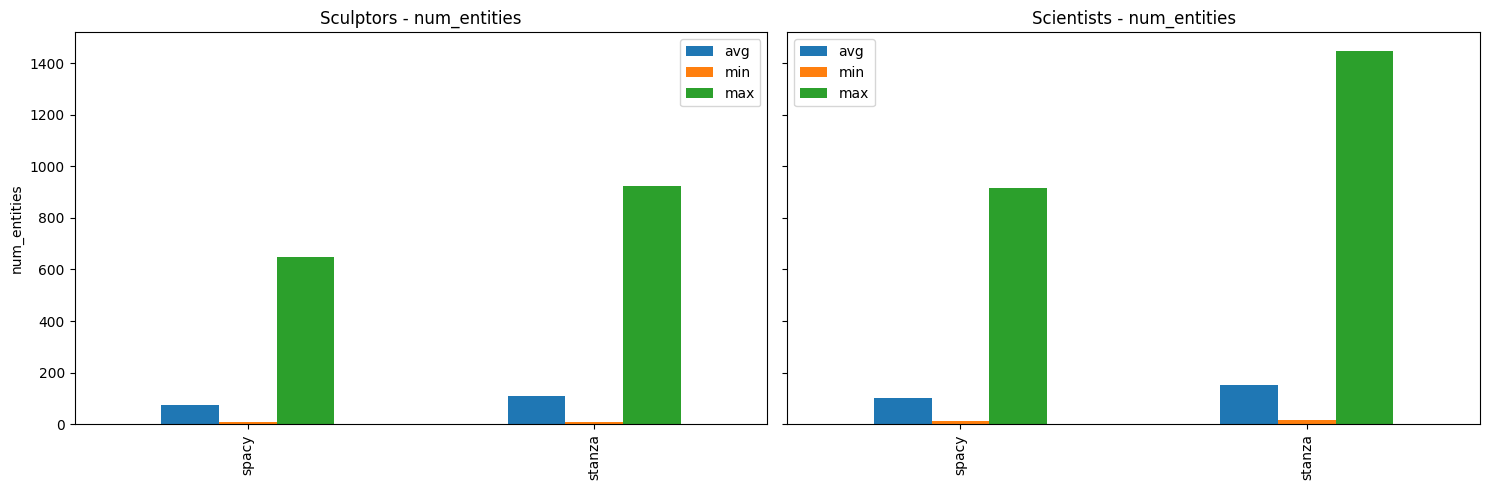

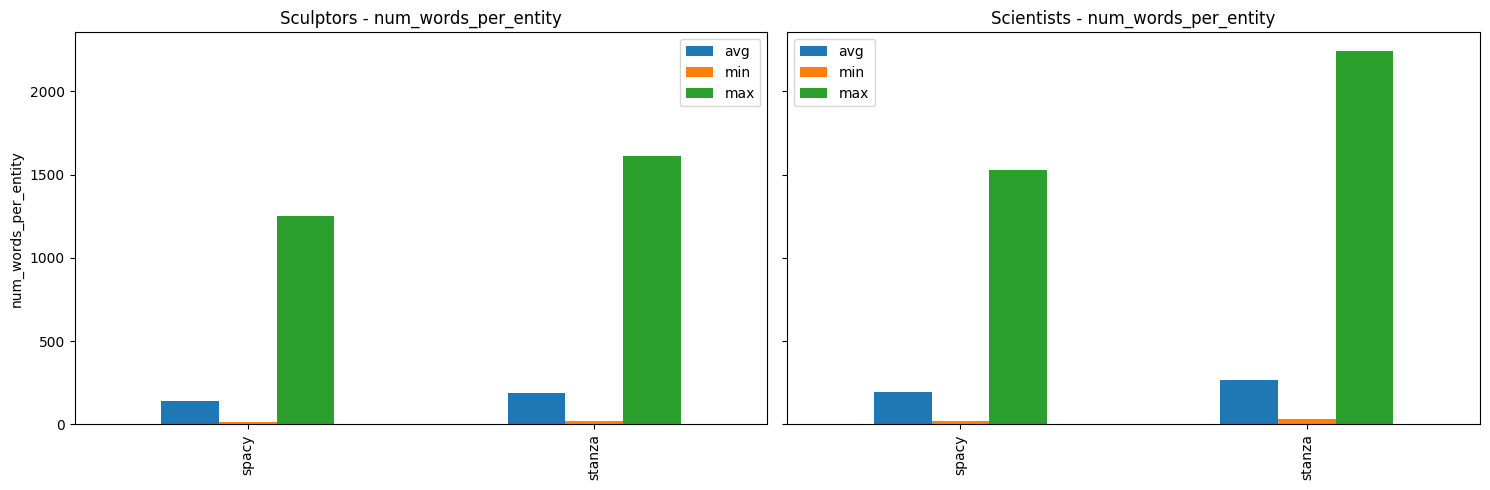

In [9]:
folder_path = rf"C:\Users\Ahana\OneDrive\Desktop\Project\Project"  
output_csv = rf"C:\Users\Ahana\OneDrive\Desktop\Project\Project\finalner.csv"  
df = process_biographies(folder_path, output_csv)
print(f"CSV file '{output_csv}' has been created.")

stats = calculate_statistics(df)
visualize_statistics(stats)